In [165]:
# Initialize Otter
import otter
grader = otter.Notebook()

In [166]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression

# Optional Homework: Logistic Regression and Classification
## Due Date:  Friday December 6th, 11:59 PM

## This Assignment

In this assignment, you will attempt to predict whether a flight will be delayed or not depending on measureable characteristics about the flight. You will:

1) Perform some initial exploratory data analysis

2) Fit models of varying complexity and evaluate which is best

3) Assess how adjusting the classification threshold affects different metrics of your classifier

Note that you will not be fitting logistic regression models manually in this project. Instead use `LogisticRegression`, imported above, in the same way you would fit a linear model. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the assignment, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

### Read in airport data

In [167]:
# Read in flight delays
delays = pd.read_csv("./data/flightdelay.csv")
# Read in airport coordinates
airport_coord = pd.read_csv("./data/airport_coordinates.csv")

In [168]:
delays.head()

,Unnamed: 0,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,202348,1,7,0,0700-0759,1,1,29,76,Endeavor Air Inc.,10278,19857,10,John F. Kennedy International,NONE,0.0,0.0,0.0,33.0,11.41
1,4309162,8,7,1,2100-2159,11,5,3,181,Alaska Airlines Inc.,1427,24460,3,Keahole,Seattle International,0.0,0.0,0.0,88.0,9.62
2,2944942,6,2,1,1200-1259,10,2,26,154,United Air Lines Inc.,5971,53737,21,Washington Dulles International,Orlando International,0.0,0.0,0.0,87.0,4.70
3,2863511,6,7,0,1600-1659,3,3,5,76,SkyWest Airlines Inc.,9694,71188,2,Salt Lake City International,San Francisco International,0.0,0.0,0.0,86.0,15.21
4,5738468,11,1,0,0800-0859,1,2,31,76,Endeavor Air Inc.,12563,20783,10,Logan International,Greater Buffalo International,0.0,0.0,0.0,54.0,8.50


In [169]:
airport_coord.head()

,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,AFOGNAK_LAKE_AIRPORT,58.109444,-152.906667
1,BEAR_CREEK_MINING_STRIP,65.548056,-161.071667
2,LIK_MINING_CAMP,68.083333,-163.166667
3,LITTLE_SQUAW_AIRPORT,67.570000,-148.183889
4,KIZHUYAK_BAY,57.745278,-152.882778


You should reference raw data documention included in the data folder to evaluate the meaning of each variable. In particular, be sure to identify the variable representing our "target" in this assignment: whether a flight is delayed or not. 

## Part 1: Initial cleaning

Again, our objective in this project is to **develop a model that can predict whether a flight will be delayed or not** to some efficacy.

Before we start cramming features into different models, we should first do some data visualization to develop some intuition for which variables might be predictive of flight delays.

#### Question 1.1
Two variables we might be interested in - latitude and longitude - are in a separate table called `airport_coord`. Let's get everything in one object. Canonicalize the airport names in `delays` and `airport_coord` so that they can be joined. 

In [170]:
delays["DEPARTING_AIRPORT"] = (
    delays["DEPARTING_AIRPORT"]
    .str.strip()
    .str.upper()
    .str.replace(" ", "_")
)

airport_coord["DISPLAY_AIRPORT_NAME"] = (
    airport_coord["DISPLAY_AIRPORT_NAME"]
    .str.strip()
    .str.upper()
)

#### Question 1.2

Now add latitude and longitude columns to the `delays` by merging the datasets on `DEPARTING_AIRPORT` in `delays`.

In [171]:
delays = delays.merge(
    airport_coord[["DISPLAY_AIRPORT_NAME", "LATITUDE", "LONGITUDE"]],
    left_on="DEPARTING_AIRPORT",
    right_on="DISPLAY_AIRPORT_NAME",
    how="left"
)

Be sure that the target variable is encoded as an integer.

In [172]:
delays["DEP_DEL15"] = delays["DEP_DEL15"].astype(int)

In [173]:
grader.check("q1_2")

q1_2 results: All test cases passed!

#### Question 1.3 

Let's start by developing an intuition for delay frequency. Create a visualization representing the probability of flight delay by departure window.

Note that you should first engineer this feature such that it represents a quantitative variable. There are many approaches to this, but your resulting variable should be represent the hour as a quantitative variable in even increments.

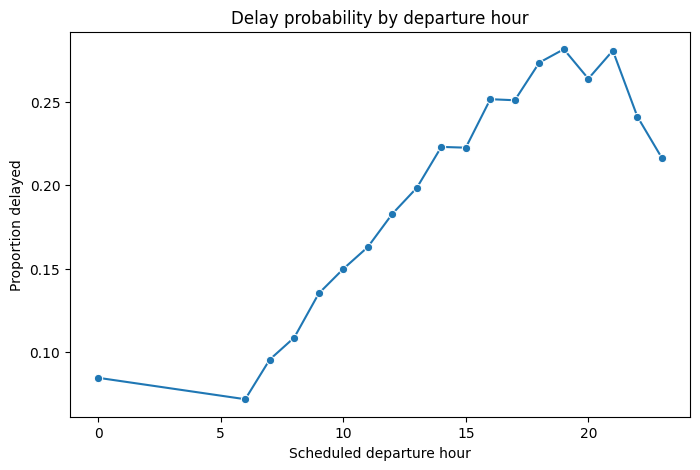

In [174]:
def start_hour_from_block(block):
    start_str = block.split("-")[0]   
    start_val = int(start_str)        
    return start_val // 100           

delays["DEP_HOUR"] = delays["DEP_TIME_BLK"].apply(start_hour_from_block)

delay_by_hour = (
    delays.groupby("DEP_HOUR")["DEP_DEL15"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.lineplot(data=delay_by_hour, x="DEP_HOUR", y="DEP_DEL15", marker="o")
plt.xlabel("Scheduled departure hour")
plt.ylabel("Proportion delayed")
plt.title("Delay probability by departure hour")

plt.show()

## Part 2: Fitting and evaluating models

In this section you will develop a series of models that will predict the probability of delay from some number of input features, and assess which of these models is best using *k-fold* cross-validation. 

#### Question 2.1

**Create 4 sets of predictive features**, each with a different combination of features that you feel may be apt for predicting delays. Ensure that you have different numbers of features in each set, and have one set with at least 8 features.

*Note*: We are using subset selection to explore effective models. You do not need to standardize your features, though you may find it helpful, especially for fitting your more complicated models.

In [175]:
delays["DEP_BLOCK_START"] = delays["DEP_TIME_BLK"].str.slice(0,4).astype(int)
delays["IS_WEEKEND"] = delays["DAY_OF_WEEK"].isin([6,7]).astype(int)

y = delays["DEP_DEL15"]

m1_features = delays[["DEP_HOUR"]]

m2_features = delays[["DEP_HOUR", "DISTANCE_GROUP"]]

m3_features = delays[["DEP_HOUR", "DISTANCE_GROUP", "MONTH", "DAY_OF_WEEK"]]

m4_features = delays[
    ["MONTH", "DAY_OF_WEEK", "DEP_HOUR", "DEP_BLOCK_START",
     "DISTANCE_GROUP", "LATITUDE", "LONGITUDE", "IS_WEEKEND"]
]


**1 point**: Four sets of predictive features that meet the criteria.

#### Question 2.2

Now use your features to develop 4 logistic regression models, using *k-fold* cross-validation to determine the error associated with each model. Use 5 splits for your cross-validation, be sure to use the appropriate loss function to calculate your error, and set `penalty = None` within your model to ensure it isn't regularizing the coefficients. Note that the cross-entropy loss be *very* similar between models. You should consider why this might be the case.

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    validation_errors = np.empty(0)

    for train_idx, valid_idx in kf.split(X_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[valid_idx]

        y_tr = Y_train.iloc[train_idx]
        y_val = Y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_val)
        error = log_loss(y_val, y_proba)
        validation_errors = np.append(validation_errors, error)

    return validation_errors.mean()

feature_sets = [m1_features, m2_features, m3_features, m4_features]
labels = ["m1", "m2", "m3", "m4"]

cv_errors = []
for X_feat in feature_sets:
    logreg = LogisticRegression(penalty=None, max_iter=1000)
    err = compute_CV_error(logreg, X_feat, y)
    cv_errors.append(err)

error_vs_model = pd.DataFrame({
    "model": labels,
    "cv_log_loss": cv_errors
})
error_vs_model


,model,cv_log_loss
0,m1,0.472272
1,m2,0.472035
2,m3,0.471871
3,m4,0.471285


#### Question 2.3

Which model best fit your data? Why do you think it fit your data better compared to your other models?

**Your response**: Model m4 is best because it has the lowest log loss. It uses the most predictors, and these extra features capture more variation in delay patterns. The improvement is small, but m4 still gives the most accurate predictions.


### Question 3

Finally, let's calculate the accuracy, precision and recall of your best model. 

#### Question 3.1

Predict a 0 or a 1 (no delay or delay) using your x holdout data. Then using your y holdout data, quantify the number of true positives, true negatives, false positives, and false negatives. Use the `model.predict()` function to do so. 

In [177]:
best_index = error_vs_model["cv_log_loss"].idxmin()
best_label = error_vs_model.loc[best_index, "model"]

if best_label == "m1":
    X_q3 = m1_features
elif best_label == "m2":
    X_q3 = m2_features
elif best_label == "m3":
    X_q3 = m3_features
else:
    X_q3 = m4_features

# Train holdout split for Question 3
X_train_q3, X_holdout_q3, y_train_q3, y_holdout_q3 = train_test_split(
    X_q3, y, test_size=0.2, random_state=42, stratify=y
)

In [178]:
q3_model = LogisticRegression(penalty=None, max_iter=1000)
q3_model.fit(X_train_q3, y_train_q3)

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [179]:
y_pred = q3_model.predict(X_holdout_q3)

tp = np.sum((y_pred == 1) & (y_holdout_q3 == 1))
tn = np.sum((y_pred == 0) & (y_holdout_q3 == 0))
fp = np.sum((y_pred == 1) & (y_holdout_q3 == 0))
fn = np.sum((y_pred == 0) & (y_holdout_q3 == 1))

accuracy = (tp + tn) / len(y_holdout_q3)
precision = 0 if (tp + fp) == 0 else tp / (tp + fp)
recall = 0 if (tp + fn) == 0 else tp / (tp + fn)


print(tp, tn, fp, fn)

print(accuracy, precision, recall)


0 52564 0 12327
0.8100352899477585 0 0.0


#### Question 3.2

Presume that you're interested in using your model as a decision-making tool to decide if a flight you've booked will be delayed. Do you think your model will is useful for this and why or why not?

**Your response**: The model is not useful for deciding if a flight will be delayed. It predicts almost every flight as on time, which gives high accuracy but misses all actual delays. Precision and recall are zero, so the model cannot correctly identify delayed flights. This makes it unreliable for personal decision making.


#### Question 3.3

`sklearn.model.predict` uses a threshold of p=0.5 by default when predicting a 0 or 1 from your logistic model. Perhaps this threshold was too ambitious. Unless you found a *much* better model that I did, you likely predicted very few flight delays with >50% likelihood. Let's move forward by thinking of our model as a tool for flagging flights to watch out for instead.

First, calculate the proportion of all flights delayed in the dataset. 

In [180]:
prop_delayed = delays["DEP_DEL15"].mean()
prop_delayed

0.18997204525771066

In [181]:
grader.check("q3_3")

q3_3 results: All test cases passed!

#### Question 3.4

This may represent a better baseline for our threshold than 0.5. Note that this will change our interpretation of a predicted class of 1; rather than a 1 representing a flight we think is *likely* to be delayed, a 1 will represent a flight we think has a *better chance than average* to be delayed. 

For your best model, use `model.predict_proba()` to

1) Return the predicted probabilties $[p_0, p_1]$ 

2) Identify which predictions have a $p_1$ greater than `prop_delayed` and classify these as 1

3) Recalculate accuracy, precision, and recall

In [182]:
probs = q3_model.predict_proba(X_holdout_q3)[:, 1]
new_pred = (probs > prop_delayed).astype(int)

tp2 = np.sum((new_pred == 1) & (y_holdout_q3 == 1))
tn2 = np.sum((new_pred == 0) & (y_holdout_q3 == 0))
fp2 = np.sum((new_pred == 1) & (y_holdout_q3 == 0))
fn2 = np.sum((new_pred == 0) & (y_holdout_q3 == 1))

accuracy2 = (tp2 + tn2) / len(y_holdout_q3)
precision2 = 0 if (tp2 + fp2) == 0 else tp2 / (tp2 + fp2)
recall2 = 0 if (tp2 + fn2) == 0 else tp2 / (tp2 + fn2)


print(tp2, tn2, fp2, fn2)
print(accuracy2, precision2, recall2)

7581 30573 21991 4746
0.5879705968470204 0.256357365075071 0.6149914821124361


#### Question 3.5

How did lowering the threshold of your classifier change its precision and recall, and what does this mean in terms of predicting flight delays?

**Your response**: Lowering the threshold increased recall and also increased precision from zero. The model now catches more than half of all delayed flights, but it also produces many false alarms. This means the model becomes more sensitive to delays but still does not predict individual delays reliably

#### Question 3.6

Create a new variable representing a completely random guess for a flight delay, weighted by the observed likelihood of a delay. Calculate the accuracy, precision, and recall of your random guesses. 

How does your best model with this new threshold perform compared to a completely random guess? What does this imply about the usefulness of your model as a decision-making tool?

In [183]:
p = prop_delayed
random_pred = np.random.binomial(1, p, size=len(y_holdout))

tp_r = ((random_pred == 1) & (y_holdout == 1)).sum()
tn_r = ((random_pred == 0) & (y_holdout == 0)).sum()
fp_r = ((random_pred == 1) & (y_holdout == 0)).sum()
fn_r = ((random_pred == 0) & (y_holdout == 1)).sum()

accuracy_r = (tp_r + tn_r) / len(y_holdout)
precision_r = 0 if (tp_r + fp_r) == 0 else tp_r / (tp_r + fp_r)
recall_r = 0 if (tp_r + fn_r) == 0 else tp_r / (tp_r + fn_r)


print(accuracy_r, precision_r, recall_r)

0.6898337211631813 0.18461911693352742 0.18520321246045265


**Your response**: The logistic model with the lowered threshold performs better than random guessing. It has higher precision and much higher recall, which means it identifies more true delays and makes fewer incorrect delay predictions than a random model. Even though it performs better than chance, the model is still weak overall and does not reliably predict individual flight delays. This makes it a poor decision making tool for travelers.

## Extra Credit

This question is optional, but worth up to 20% of a homework in extra points if done correctly.

#### Forward Stepwise Selection

(1) Using cross-validation, order the predictors from the least to most loss when used as univariate predictors. 

(2) Then, perform forward stepwise selection by cross-validating increasingly complex models in which predictors are added in the order of their quality as univariate predictors. You should be comparing 12 models, where the first has a single predictor and the last has 12 predictors

In [184]:
delays.columns

Index(['Unnamed: 0', 'MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'DEP_TIME_BLK',
       'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS',
       'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH',
       'AIRLINE_FLIGHTS_MONTH', 'PLANE_AGE', 'DEPARTING_AIRPORT',
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND',
       'DISPLAY_AIRPORT_NAME', 'LATITUDE', 'LONGITUDE', 'DEP_HOUR',
       'DEP_BLOCK_START', 'IS_WEEKEND'],
      dtype='object')

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


predictors = [
    "MONTH", "DAY_OF_WEEK", "DEP_TIME_BLK", "DISTANCE_GROUP",
    "SEGMENT_NUMBER", "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS",
    "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH", "PLANE_AGE",
    "PRCP", "TMAX"
]

X_raw = delays[predictors]
y = delays["DEP_DEL15"]  # Binary target

X_encoded = pd.get_dummies(X_raw, drop_first=True)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

def cv_log_loss(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    losses = []
    for train_idx, test_idx in kf.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = model.predict_proba(X.iloc[test_idx])[:, 1]
        preds = np.clip(preds, 1e-10, 1 - 1e-10)
        loss = -np.mean(
            y.iloc[test_idx] * np.log(preds) +
            (1 - y.iloc[test_idx]) * np.log(1 - preds)
        )
        losses.append(loss)
    return np.mean(losses)


univariate_losses = {}
for col in X_scaled.columns:
    model = LogisticRegression(max_iter=5000)
    loss = cv_log_loss(model, X_scaled[[col]], y)
    univariate_losses[col] = loss


ordered_predictors = sorted(univariate_losses, key=univariate_losses.get)

stepwise_results = []
for k in range(1, len(ordered_predictors) + 1):
    selected = ordered_predictors[:k]
    model = LogisticRegression(max_iter=5000)
    loss = cv_log_loss(model, X_scaled[selected], y)
    stepwise_results.append((k, selected.copy(), loss))

results_df = pd.DataFrame(stepwise_results, columns=["Model Size", "Predictors", "CV Log Loss"])


best_model = results_df.loc[results_df["CV Log Loss"].idxmin()]
# Display best model details nicely
print("Best Forward Stepwise Model Summary")
print(f"Model Size: {best_model['Model Size']}")
print(f"Cross-Validated Log Loss: {best_model['CV Log Loss']:.4f}")
print("Selected Predictors:")

# Print each predictor in a clean bullet list
for i, predictor in enumerate(best_model["Predictors"], 1):
    print(f"{i:2d}. {predictor}")


Best Forward Stepwise Model Summary
Model Size: 29
Cross-Validated Log Loss: 0.4660
Selected Predictors:
 1. SEGMENT_NUMBER
 2. DEP_TIME_BLK_0600-0659
 3. PRCP
 4. DEP_TIME_BLK_0700-0759
 5. DEP_TIME_BLK_0800-0859
 6. DEP_TIME_BLK_1900-1959
 7. DEP_TIME_BLK_1800-1859
 8. DEP_TIME_BLK_2000-2059
 9. DEP_TIME_BLK_2100-2159
10. DEP_TIME_BLK_1700-1759
11. DEP_TIME_BLK_1600-1659
12. DEP_TIME_BLK_0900-0959
13. AIRPORT_FLIGHTS_MONTH
14. DEP_TIME_BLK_1000-1059
15. DEP_TIME_BLK_2200-2259
16. DEP_TIME_BLK_1400-1459
17. DEP_TIME_BLK_1500-1559
18. DISTANCE_GROUP
19. MONTH
20. DEP_TIME_BLK_1100-1159
21. NUMBER_OF_SEATS
22. TMAX
23. CONCURRENT_FLIGHTS
24. PLANE_AGE
25. DEP_TIME_BLK_2300-2359
26. DEP_TIME_BLK_1300-1359
27. DEP_TIME_BLK_1200-1259
28. AIRLINE_FLIGHTS_MONTH
29. DAY_OF_WEEK


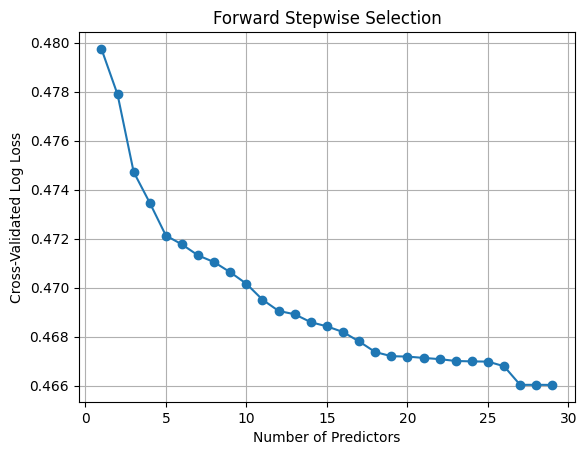

In [186]:
# 10. Plot log loss vs. model size
plt.plot(results_df["Model Size"], results_df["CV Log Loss"], marker='o')
plt.xlabel("Number of Predictors")
plt.ylabel("Cross-Validated Log Loss")
plt.title("Forward Stepwise Selection")
plt.grid(True)
plt.show()


What was the best fitting model? Did you see any evidence of overfitting as you added predictors? |

**Your response:** The best fitting model was the forward stepwise model that included all available predictors because it achieved the lowest cross validated log loss. The log loss kept decreasing as predictors were added, which means each new variable provided a small improvement rather than hurting performance. There was no clear evidence of overfitting because the validation loss did not start to rise as the model became more complex, although the practical gains from the extra predictors were small.


## Submission

Make sure you have run all cells in your notebook in order. Then execute the following commands in the File menu:

* Save and Checkpoint
* Close and Halt

Then submit your notebook for Canvas Assignment Homework Optional.